# Machine Learning Engineer Nanodegree

### Capstone Project: Starbucks’ Capstone Challenge - Notebook 4.

***Maria Balog  
May 22th, 2020***

### Recap

This project is broken down into a number of notebooks to facilitate ease of testing and trouble-shooting. This is the fourth notebook of this project, for a full description of the problem, please refer to the first notebook [*here*](Starbucks_Capstone_notebook.ipynb).

In brief, we have a month worth of data for about 15,000 users who may or may not have acted upon digital offers received from Starbucks. 

### Problem Statement

Our main areas of query are, for what demographic groups and what offer types  
- are offers most likely to be viewed within their valid duration?
- are offers most likely to be completed, given that they were viewed?
- can we find a correlation between an offer being viewed and the total amount of transactions within the duration of the offer?


### Implementation

The implementation of the solution consists of the following steps:
- data cleaning and visualization (see [*Notebook 1.*](Starbucks_Capstone_notebook.ipynb))
- feature engineering (see [*Notebook 2.*](Starbucks_Capstone_notebook3.ipynb))
- applying KMeans clustering to examine viewing rates (see [*Notebook 3.*](Starbucks_Capstone_notebook4.ipynb))
- applying KMeans clustering to examine completion rates
- applying KMeans clustering to examine total transaction amounts
- final evaluation and conclusions

In this notebook, we will focus on the fourth step: **applying KMeans clustering to examine completion rates**.

In this case, we need to examine the combination of the `offer_received`, `offer_viewed` and `offer_completed` datasets, joined with the `portfolio` and `profile` datasets using their appropriate ids.

We have already created this dataset in our second notebook, so let's load it in!

In [1]:
import pandas as pd
import numpy as np
import math

dtype_ocp  = {'age': np.int8,  'male': np.int8,  'female': np.int8,  'other': np.int8 ,
              'member_days': np.int16,  'reward': np.int8,  'difficulty': np.int8,
              'duration': np.int16,  'web': np.int8,  'mobile': np.int8,  'social': np.int8,
              'bogo': np.int8,  'disc': np.int8,  'is_completed': np.int8 } 
offer_comp = pd.read_csv('data/offer_completed_profile.csv', dtype=dtype_ocp)
#offer_comp.info()


Again, this is the combination of the demographic data and the properties of the offers that were received, viewed and possibly completed by each user.

Implementing KMeans clustering and interpreting the data requires the following steps:
- standardization 
- principal component analysis (PCA)
- determining the optimal K value(s)
- performing KMeans clustering
- reversing PCA and standardization on the cluster centers
- interpreting the results

### Standardization

First we need to standardize the data, so that each column's mean is `0` and their standard deviation is `1`.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_ocp = pd.DataFrame(scaler.fit_transform(offer_comp.astype(float)))
scaled_ocp.columns = offer_comp.columns
scaled_ocp.describe().round(4)

,age,income,member_days,female,male,other,reward,difficulty,duration,web,mobile,social,bogo,disc,is_completed
count,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000,49034.0000
mean,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-2.1594,-1.7258,-1.3049,-0.8650,-1.1202,-0.1255,-1.0641,-1.1265,-1.1574,-2.4587,-4.0907,-1.8166,-1.0613,-0.9422,-1.1687
25%,-0.6947,-0.7357,-0.7665,-0.8650,-1.1202,-0.1255,-1.0641,-0.5453,-1.1574,0.4067,0.2445,0.5505,-1.0613,-0.9422,-1.1687
50%,0.0669,-0.0757,-0.3392,-0.8650,0.8927,-0.1255,-0.1162,0.3265,-0.0355,0.4067,0.2445,0.5505,0.9422,-0.9422,0.8557
75%,0.7114,0.6787,0.6699,1.1561,0.8927,-0.1255,1.4637,0.3265,-0.0355,0.4067,0.2445,0.5505,0.9422,1.0613,0.8557
max,2.7034,2.5174,3.0962,1.1561,0.8927,7.9698,1.4637,3.2325,1.6472,0.4067,0.2445,0.5505,0.9422,1.0613,0.8557


### Principal Component Analysis for Dimentionality Reduction

Next, we can examine the principal components of this dataset. In our previous notebook we already worked out this process in detail, so here we will streamline it and make it more efficient.

#### *Figuring out how many principal components to keep*

In [3]:
# first set PCA components to the number of features -1
pca = PCA(n_components=14)
pca.fit(scaled_ocp)

explained_vr = pca.explained_variance_ratio_.round(4)

# cheking the sums of the explained variance for the first ii components
for ii in range(1,13):
    print('Variance percentage with {} components: {}%'.format(ii, (explained_vr[:ii].sum()*100).round(2)))

Variance percentage with 1 components: 25.88%
Variance percentage with 2 components: 40.21%
Variance percentage with 3 components: 53.08%
Variance percentage with 4 components: 61.28%
Variance percentage with 5 components: 68.8%
Variance percentage with 6 components: 75.95%
Variance percentage with 7 components: 82.78%
Variance percentage with 8 components: 88.28%
Variance percentage with 9 components: 92.86%
Variance percentage with 10 components: 96.94%
Variance percentage with 11 components: 98.65%
Variance percentage with 12 components: 99.82%


This means that by keeping the first ten components, we can retain about 97% of variability of the data. 

#### *Visualizing the top ten principal components*

Below is a visual representation of the composition of the first ten components (here I use absolute values because I am only interested in the weight of the columns in each component).

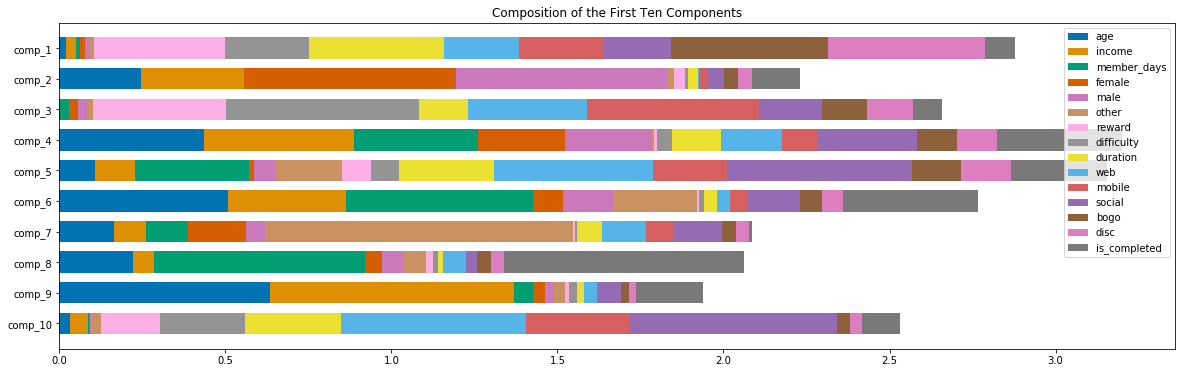

In [4]:
import sys  
sys.path.insert(0, './source')
        
import sb_data_visualization as dv
import sb_modeling as modeling

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# convert the array of principal components to a dataframe
data = pd.DataFrame(np.abs(pca.components_[:10]))

rows = ['comp_'+str(ii) for ii in range(1, 11)]
columns = offer_comp.columns

data.index = rows    
data.columns = columns

dv.display_principal_components(data) 

So keeping ten principal components and retaining over 95% variability of the data seems reasonable. 

In [5]:
# keep however many components result in retaining 95% variability
pca2 = PCA(.95)
pca2.fit(scaled_ocp)

explained_vr = pca2.explained_variance_ratio_.round(4)
print('\nExplained Variance Ratio: \n', explained_vr)

# the new column names are the previously generated "row" names, comp_1 to comp_10
trans_data = pd.DataFrame(pca2.transform(scaled_ocp), columns=rows)
trans_data.head().round(2)


Explained Variance Ratio: 
 [0.2588 0.1433 0.1287 0.082  0.0752 0.0715 0.0683 0.055  0.0458 0.0408]


,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10
0,-0.57,2.50,-0.51,1.74,1.13,-0.27,-0.24,-0.61,0.03,1.31
1,-1.50,2.42,-1.12,1.20,0.13,-0.60,0.02,-0.51,-0.16,-0.49
2,-1.95,2.45,1.55,0.43,-1.82,-0.77,0.49,-0.74,-0.07,0.78
3,-0.69,-0.61,-0.37,1.66,1.47,-0.53,-0.10,-1.38,0.73,1.24
4,1.76,-1.10,-0.29,0.36,1.41,-1.63,0.03,0.28,0.21,1.12


Now let's move on to fitting our clustering algorithms.

### Determining the Optimal Number of Clusters

First, let's try to use the elbow method to figure out the optimal number of clusters. Since we have ten types of promotions, I'm hoping we would have a number of clusters close to that.

The inertia, or within-cluster sum-of-squares criterion is a measure of how internally coherent clusters are. ***Lower values are better and zero is optimal.***

If the ground truth labels are not known, the Calinski-Harabasz index (also known as the Variance Ratio Criterion) can be used to evaluate the model, where ***a higher Calinski-Harabasz score relates to a model with better defined clusters***. This score is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared).

The Davies-Bouldin index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. ***A lower Davies-Bouldin index relates to a model with better separation between the clusters.*** Zero is the lowest possible score. 

Wall time: 55.6 s


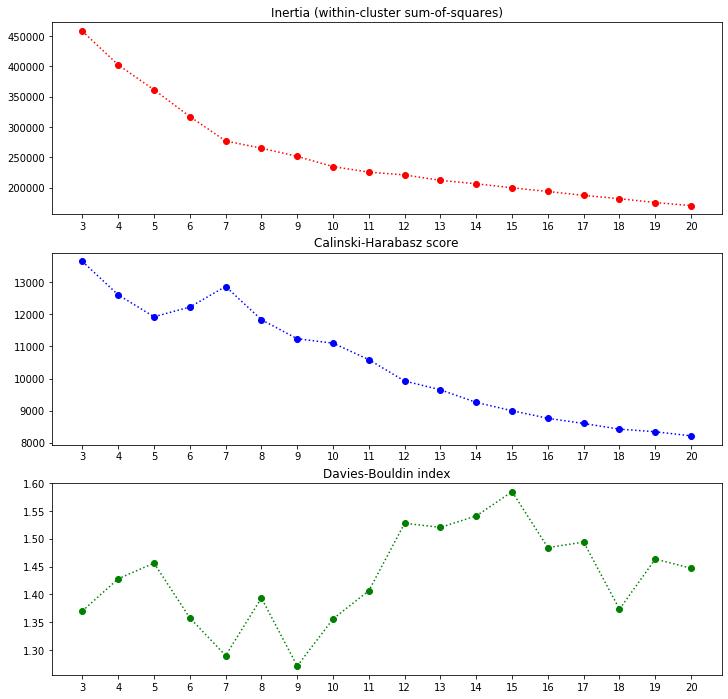

In [6]:
%%time

modeling.init_metrics(trans_data)
modeling.display_metrics()

Well, the first curve has a great elbow at `k=7`, I have run this a few times with different random seeds and I got similar curves every time.

In the second chart, higher values indicate better defined clusters, so ideally we are looking for local maximums, again, `k=7` is by far the best candidate. Values in the third chart indicate the average ‘similarity’ between clusters, and this time the ideal values are the local minima. This technically does not apply to `k=7`, but considering how it is still one of the lowest values in this range, and it is the best choice based on the other two charts, this should be the `k` value we first consider.

Let's also examine if the number of datapoints falling in each cluster for a range of `k` values would give us a clue. To that end, we can visualize the cluster sizes in various ways for `k` values ranging from 3 to 20, see if we can discover any trends.

In [7]:
%%time 
n = 21
results = pd.DataFrame(index=range(n-1))
for ii in range(3, n):
    results['count'+str(ii)] = modeling.get_cluster_counts(trans_data, n, ii)


Wall time: 55.4 s


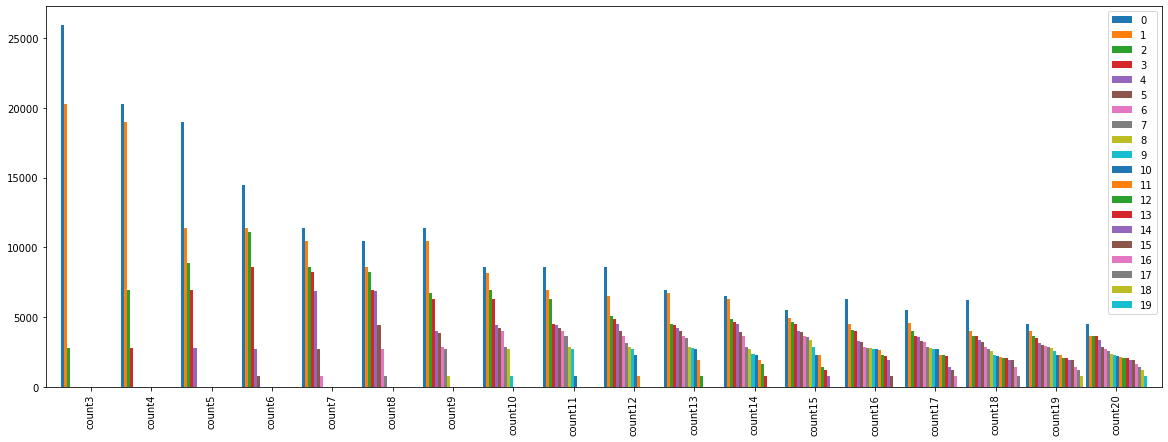

In [8]:
ax = results.transpose().plot.bar(figsize=(20, 7), width=1);

The clusters for each `k` value are relatively close in size, which is usually a good sign. We can also notice that some of the cluster sizes remain the same as we increase the number of cluster centers, which means those clusters are not easily broken up or reorganized into smaller clusters. Below is a more precise representation of these trends.

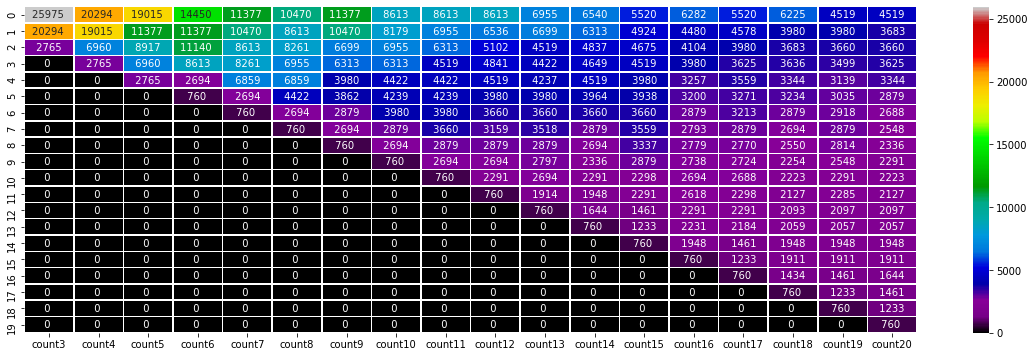

In [9]:
dv.display_cluster_sizes(results)

Indeed, for `k=7` the clusters are super stable, both going from `k=6` to `k=7` and from `k=7` to `k=8`, each time only one cluster changes, the one that contained 18731 datapoints in `k=6`  and the one that contained 6859 datapoints in `k=7` is broken up into two clusters. 

Based on all the above charts, `k=7` is the optimal number of clusters.


### Performing KMeans Clustering and Reversing PCA and Standardization on the Cluster Centers

After running KMeans clustering for `k=7`, we will get seven ten-dimensional centroids, that can be considered representative datapoints for our entire dataset. However, to interpret them, we still need to consider how PCA and standardization affected the original features.

In order to recover the original feature values for each centroid, we can to use the `PCA.inverse_transform()` method, to get our 15-dimensional datapoints, then call `StandardScaler.inverse_transform()` to scale back to the original values. To this end, I have created a general method, that we can utilize in case we decide to try a few different `k` values.

In [10]:
%%time

result_df = modeling.get_orig_cluster_centers(trans_data, columns, 7, pca2, scaler)

Wall time: 2.49 s


In [11]:

result_df.sort_values(by='is_completed', ascending=False).round(2)

,age,income,member_days,reward,difficulty,duration,web,mobile,social,is_completed,count,gender,offer_type
2,57.65,71847.03,625.30,2.22,8.64,8.33,1.0,1.0,1.0,0.68,8613,female,disc
5,56.87,69808.60,612.35,5.66,20.87,9.95,1.0,0.0,0.0,0.64,2694,male,disc
6,54.95,65472.85,593.58,5.11,9.17,7.27,1.0,1.0,1.0,0.63,760,other,bogo
1,52.64,62648.08,639.77,2.22,8.65,8.35,1.0,1.0,1.0,0.61,11377,male,disc
0,57.58,72111.48,609.48,6.95,6.93,5.21,1.0,1.0,1.0,0.60,8261,female,bogo
4,52.88,62667.80,636.88,6.96,6.92,5.20,1.0,1.0,1.0,0.49,10470,male,bogo
3,53.96,64831.29,619.88,10.13,10.13,7.26,0.0,1.0,1.0,0.48,6859,male,bogo


In [22]:
df = result_df.corr().round(2)
df[['is_completed']].style.background_gradient(cmap='coolwarm')

,is_completed
age,0.64
income,0.61
member_days,-0.34
reward,-0.77
difficulty,0.3
duration,0.58
web,0.61
mobile,-0.3
social,-0.3
is_completed,1


While there seems to be a definite correlation between the `is_completed` flag and some of the individual columns, the variance of the `is_completed` flag between the seven cluster centers are not very high, so we cannot really infer strong trends by analysing these clusters. (Also, strong negative correlation with the `reward` column definitely seems like a fluke.)

### Increasing the Number of Clusters for a More Granular Breakdown

As before, we can try to find a larger `k` to perform a more granular analysis. Again, we are looking for a value that has an elbow on the first chart, sort of a bump on the second chart and a dip on the third chart. This makes `k=18` a fairly good option.


In [15]:
results_df = modeling.get_orig_cluster_centers(trans_data, columns, 18, pca2, scaler)

In [16]:
results_df.describe().round(2)

,age,income,member_days,reward,difficulty,duration,web,mobile,social,is_completed,count
count,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00
mean,54.73,66241.51,664.47,5.40,9.49,7.14,0.89,0.89,0.72,0.58,2724.11
std,5.75,9109.47,271.24,2.81,4.32,1.73,0.32,0.32,0.46,0.28,1110.59
min,42.75,50746.88,361.51,1.57,5.66,4.93,0.00,0.00,0.00,-0.00,760.00
25%,51.70,59457.97,588.16,2.36,7.43,5.25,1.00,1.00,0.25,0.46,1991.75
50%,55.11,67485.80,607.24,5.38,8.64,7.26,1.00,1.00,1.00,0.63,2760.50
75%,57.71,71056.49,641.15,7.66,9.06,8.35,1.00,1.00,1.00,0.70,3628.75
max,65.69,86815.37,1419.63,10.14,20.88,9.95,1.00,1.00,1.00,1.00,4650.00


In [24]:
df = results_df.corr().round(2)
df[['is_completed']].style.background_gradient(cmap='coolwarm')

,is_completed
age,0.34
income,0.36
member_days,0.15
reward,-0.28
difficulty,0.07
duration,0.24
web,0.1
mobile,-0.08
social,-0.14
is_completed,1


Based on correlation between individual columns, we find that in this case, there is only a slight positive coorelation with the `duration`, `income` and `age` columns, but the variance is quite low for the `income` and `age` columns, so it is harder to define distinct categories based on these columns.

In [18]:
results_df.sort_values(by=['gender', 'offer_type', 'is_completed'], ascending=[True, True, False]).round(2)

,age,income,member_days,reward,difficulty,duration,web,mobile,social,is_completed,count,gender,offer_type
10,57.91,74107.87,645.03,7.59,7.23,4.98,1.0,1.0,1.0,1.00,3622,female,bogo
8,58.11,71242.77,622.08,4.64,5.67,6.03,1.0,1.0,0.0,0.67,1948,female,bogo
11,57.11,69628.93,606.56,10.14,10.13,7.26,0.0,1.0,1.0,0.59,2879,female,bogo
4,57.07,70497.63,530.21,7.75,7.44,4.93,1.0,1.0,1.0,0.00,2642,female,bogo
16,65.69,86815.37,654.12,2.21,8.67,8.34,1.0,1.0,1.0,0.71,4650,female,disc
14,59.05,72582.10,617.60,5.66,20.88,9.94,1.0,0.0,0.0,0.66,1233,female,disc
3,48.20,54316.54,586.36,2.22,8.61,8.32,1.0,1.0,1.0,0.64,3947,female,disc
13,55.48,68019.25,596.07,7.40,7.00,4.99,1.0,1.0,1.0,1.00,3224,male,bogo
9,53.77,65397.69,657.48,4.63,5.66,6.03,1.0,1.0,0.0,0.63,2254,male,bogo
2,51.69,61360.83,629.51,10.13,10.13,7.26,0.0,1.0,1.0,0.41,3980,male,bogo


#### *Section Summary*

If we group the clusters by `gender` and `offer_type`, we get an even clearer trend of higher completion rates for longer membership terms, with the exception of cluster 6. Beyond that, the completion rate seems to be virtually independent from all the other variables in this dataset, which might be due to various reasons: it may depend on variables we have not recorded, there might be some inconsistencies with the way the `offer completed` events are recorded, or of course it is psooible that aggregating the data in a different fashion would yield in cleaer results.


Next, we examine trends in [**transactions**](Starbucks_Capstone_notebook6.ipynb).